### Import required libraries

In [2]:
import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

from sklearn.model_selection import train_test_split, learning_curve
from sklearn.metrics import average_precision_score

from xgboost.sklearn import XGBClassifier
from xgboost import plot_importance, to_graphviz

In [3]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

### Import data and correct spelling of original column headers for consistency

In [4]:
df = pd.read_csv("paysim1/dataset.csv")
df = df.rename(columns={'oldbalanceOrg':'oldBalanceOrig', 'newbalanceOrig':'newBalanceOrig', \
                        'oldbalanceDest':'oldBalanceDest', 'newbalanceDest':'newBalanceDest'})
df.head()

,step,type,amount,nameOrig,oldBalanceOrig,newBalanceOrig,nameDest,oldBalanceDest,newBalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


### Test if there any missing values in DataFrame.

In [5]:
print(df.isna().values.any())
print(df.isnull().values.any())

False
False


#### It turns out there are no obvious missing values but, but missing information have proxies of numerical value 0.

### 2. Exploratory Data Analysis
In this section, we present some insights into this dataset using Pandas Dataframe methods. More elaborate visualizations follow in subsequent sections. 

#### 2.1. Which types of transactions are fraudulent? 
During analysis we found that fraud happens namely in only two type of transactions 'TRANSFER' and 'CASHOUT'. 'TRANSFER' is where money is sent to a customer/fraudster and 'CASH_OUT' where money is sent to a merchant who pays the customer/fraudster in cash. Also, it is to be noted that the number of fraudulent TRANSFERs almost equals the number of fraudulent CASH_OUTs. These observations in the dataset can be related to the fact that fraud is committed by first transferring out funds to another account which subsequently cashes it out.

Number of fraudulent transactions with transaction type
CASH_OUT    4116
TRANSFER    4097
Name: type, dtype: int64


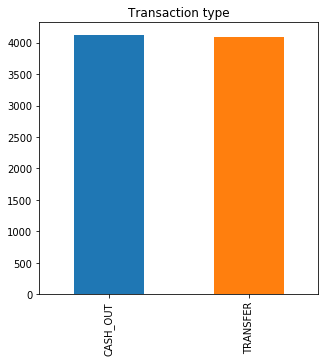

In [6]:
print("Number of fraudulent transactions with transaction type")
print(df[df.isFraud == 1].type.value_counts())
f, ax = plt.subplots(1, 1, figsize=(5, 5))
df[df.isFraud == 1].type.value_counts().plot(kind='bar', title="Transaction type", ax=ax, figsize=(5,5))
plt.show()

#### 2.2. What determines whether the feature *isFlaggedFraud* gets set or not? 
It turns out that the featur **isFlaggedFraud** being set when
an attempt is made to 'TRANSFER' an 'amount' greater than 200,000.
We plot correlation among features to better understand the relationship between them, specially how does **isFlaggedFraud** relate to others.

Correlation among different features


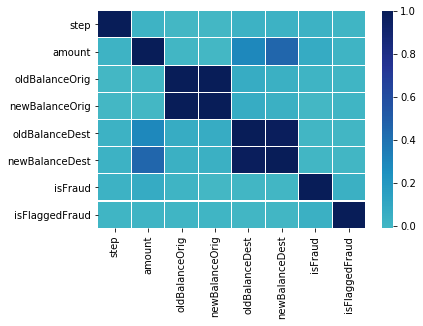

In [7]:
print("Correlation among different features")
sns.heatmap(df.corr(), center=0, linewidths=.1, linecolor='white', cmap="YlGnBu")

As we can see from correlation matrix, **isFlaggedFraud** and **step** doesn't correlate with any feature, hence it might be safe to reject them. Let's modify the **step** feature and bin it among 24 different hours from 0 to 23. We would like to see if fraud transactions are linked to specific hour of a day.

In [8]:
df['step_bin'] = df.step.apply(lambda x: x%24)

Correlation among different features after step binning


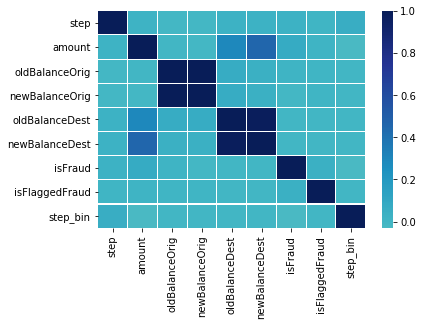

In [9]:
print("Correlation among different features after step binning")
sns.heatmap(df.corr(), center=0, linewidths=.1, linecolor='white', cmap="YlGnBu")

*Conclusion:* **isFlaggedFraud** and **step** feature doesn't affect if the transaction can be fraud or not also they don't correlate with any other feature, hence it is safe to discard them in our further exploratory analysis and modelling.

In [10]:
df.corr()

,step,amount,oldBalanceOrig,newBalanceOrig,oldBalanceDest,newBalanceDest,isFraud,isFlaggedFraud,step_bin
step,1.000000,0.022373,-0.010058,-0.010299,0.027665,0.025888,0.031578,0.003277,0.061729
amount,0.022373,1.000000,-0.002762,-0.007861,0.294137,0.459304,0.076688,0.012295,-0.029676
oldBalanceOrig,-0.010058,-0.002762,1.000000,0.998803,0.066243,0.042029,0.010154,0.003835,-0.001015
newBalanceOrig,-0.010299,-0.007861,0.998803,1.000000,0.067812,0.041837,-0.008148,0.003776,-0.000858
oldBalanceDest,0.027665,0.294137,0.066243,0.067812,1.000000,0.976569,-0.005885,-0.000513,-0.001564
newBalanceDest,0.025888,0.459304,0.042029,0.041837,0.976569,1.000000,0.000535,-0.000529,-0.006697
isFraud,0.031578,0.076688,0.010154,-0.008148,-0.005885,0.000535,1.000000,0.044109,-0.031403
isFlaggedFraud,0.003277,0.012295,0.003835,0.003776,-0.000513,-0.000529,0.044109,1.000000,-0.000462
step_bin,0.061729,-0.029676,-0.001015,-0.000858,-0.001564,-0.006697,-0.031403,-0.000462,1.000000


#### 2.3. Are expected merchant accounts properly labelled?

As per the dataset, CASH_IN involves being paid by
a merchant (whose name is prefixed by 'M'). However, we didn't find such records where
merchants are making CASH_IN type transactions to customers. 

In [11]:
print('\nAre there any merchants among originator accounts for CASH_IN \
transactions? {}'.format((df[df.type == 'CASH_IN'].nameOrig.str.contains('M')).any()))


Are there any merchants among originator accounts for CASH_IN transactions? False


Similarly, it was stated that CASH_OUT involves paying 
a merchant. However, even for CASH_OUT transactions
there are no merchants among the destination accounts.

In [12]:
print('\nAre there any merchants among destination accounts for CASH_OUT \
transactions? {}'.format((df[df.type == 'CASH_OUT'].nameDest.str.contains('M')).any()))


Are there any merchants among destination accounts for CASH_OUT transactions? False


In fact, there are no merchants among any originator accounts. Merchants are
only present in destination accounts for only PAYMENTS.

In [13]:
print('\nAre there any transactions having merchants among originator accounts? {}'.format(
    df.nameOrig.str.contains('M').any())) 

print('\nAre there any transactions having merchants among destination accounts? {} '.format(
    df.nameDest.str.contains('M').any()))
print('If yes, then what are such trasactions type?\n')
print(df[df.nameDest.str.contains('M')].type.value_counts())


Are there any transactions having merchants among originator accounts? False

Are there any transactions having merchants among destination accounts? True 
If yes, then what are such trasactions type?

PAYMENT    2151495
Name: type, dtype: int64


*Conclusion*: Among the account labels **nameOrig** and **nameDest**, for all transactions, the merchant prefix of 'M' occurs in an unexpected way and exist only for PAYMENTS

#### 2.4. Are there any relation of nameOrig and  nameDest  features to fraudulent TRANSFERs and CASH_OUTs?

From the data description, the modus operandi for committing fraud involves 
first making a TRANSFER to a (fraudulent) account which in turn 
conducts a CASH_OUT.
CASH_OUT involves transacting with a merchant who
pays out cash.
Thus, within this two-step process, the fraudulent account would be present as 
the destination in a TRANSFER
and the originator in a CASH_OUT. However, the data shows below that there are no 
such common accounts among 
fraudulent transactions. Thus, the data doesn't comply with
the expected modus-operandi.

In [14]:
dfFraudTransfer = df[(df.isFraud == 1) & (df.type == 'TRANSFER')]
dfFraudCashout = df[(df.isFraud == 1) & (df.type == 'CASH_OUT')]

print('\nWithin fraudulent transactions, are there destinations for TRANSFERS \
that \nare also originators for CASH_OUTs? {}'.format(
    (dfFraudTransfer.nameDest.isin(dfFraudCashout.nameOrig)).any()))


Within fraudulent transactions, are there destinations for TRANSFERS that 
are also originators for CASH_OUTs? False


Could destination accounts for fraudulent TRANSFERs can be originator for CASHOUTs that
are not detected as Fraud and are labeled as genuine? We will see below there are such 3 transactions

In [15]:
dfNotFraudCashout = df[(df.isFraud == 0) & (df.type == 'CASH_OUT')]
print('\nAre there any fraudulent TRANSFERs whose destination accounts are \
originators of \ngenuine CASH_OUTs: {}'.format(
    (dfFraudTransfer.nameDest.isin(dfNotFraudCashout.nameOrig)).any()))
print("If yes, what are they?")
dfFraudTransfer[dfFraudTransfer.nameDest.isin(dfNotFraudCashout.nameOrig)]


Are there any fraudulent TRANSFERs whose destination accounts are originators of 
genuine CASH_OUTs: True
If yes, what are they?


,step,type,amount,nameOrig,oldBalanceOrig,newBalanceOrig,nameDest,oldBalanceDest,newBalanceDest,isFraud,isFlaggedFraud,step_bin
1030443,65,TRANSFER,1282971.57,C1175896731,1282971.57,0.0,C1714931087,0.0,0.0,1,0,17
6039814,486,TRANSFER,214793.32,C2140495649,214793.32,0.0,C423543548,0.0,0.0,1,0,6
6362556,738,TRANSFER,814689.88,C2029041842,814689.88,0.0,C1023330867,0.0,0.0,1,0,18


In [16]:
print("Follwing genuine CASH_OUTS have originator accounts that \
are destination \naccounts in fraudulent TRANSFERs")

dfNotFraudCashout[dfNotFraudCashout.nameOrig.isin(dfFraudTransfer.nameDest)]

Follwing genuine CASH_OUTS have originator accounts that are destination 
accounts in fraudulent TRANSFERs


,step,type,amount,nameOrig,oldBalanceOrig,newBalanceOrig,nameDest,oldBalanceDest,newBalanceDest,isFraud,isFlaggedFraud,step_bin
1168398,132,CASH_OUT,29084.28,C1023330867,51999.0,22914.72,C1422447255,0.00,29084.28,0,0,12
2186261,185,CASH_OUT,214555.85,C423543548,0.0,0.00,C1066927674,4575179.83,4789735.69,0,0,17
6149940,546,CASH_OUT,18091.05,C1714931087,197227.0,179135.95,C1339132632,66177.84,84268.89,0,0,18


As we can see from step information(which is information about time), for all 3 such transactions, genuine CASH_OUT has occured either way back before a fraudulent transaction took place or way after it.

*Conclusion*: Therefore, we can conclude that **nameOrig** and **nameDest** features neither encode merchant accounts in the expected way, nor they are related to fraud modus-operandi. So, it will be safe to disregard such feature in our further explorations



### 3. Data cleaning

From the exploratory data analysis (EDA) of in previous section, we know that fraud only occurs in 'TRANSFER's and 'CASH_OUT's. So we assemble only the corresponding data in X
for analysis. Also, we remove the irrelevant features found in previous explorations.

In [17]:
X = df[(df.type == 'TRANSFER') | (df.type == 'CASH_OUT')]

# Eliminate columns shown to be irrelevant for analysis in the EDA
X = X.drop(['nameOrig', 'nameDest', 'isFlaggedFraud'], axis = 1)

# Binary-encoding of labelled data in 'type'
X.loc[X.type == 'TRANSFER', 'type'] = 0
X.loc[X.type == 'CASH_OUT', 'type'] = 1
X.type = X.type.astype(int) # convert dtype('O') to dtype(int)
X.head()

,step,type,amount,oldBalanceOrig,newBalanceOrig,oldBalanceDest,newBalanceDest,isFraud,step_bin
2,1,0,181.00,181.0,0.0,0.0,0.00,1,1
3,1,1,181.00,181.0,0.0,21182.0,0.00,1,1
15,1,1,229133.94,15325.0,0.0,5083.0,51513.44,0,1
19,1,0,215310.30,705.0,0.0,22425.0,0.00,0,1
24,1,0,311685.89,10835.0,0.0,6267.0,2719172.89,0,1


In [18]:
print(len(X))

2770409


#### 3.1. Imputation of Latent Missing Values

The data has several transactions with zero balances in the destination 
account both before and after a non-zero amount is transacted. The fraction
of such transactions, where zero denotes a missing value, is much 
larger in fraudulent (50%) compared to genuine transactions (0.06%).

In [19]:
Xfraud = X[X.isFraud == 1]
XnonFraud = X[X.isFraud == 0]
frac_fraud = len(Xfraud[(Xfraud.oldBalanceDest == 0) & \
(Xfraud.newBalanceDest == 0) & (Xfraud.amount)]) / (1.0 * len(Xfraud))

print('\nThe fraction of fraudulent transactions with \'oldBalanceDest\' = \
\'newBalanceDest\' = 0 \nalthough the transacted \'amount\' is non-zero is: {}'.\
format(round(frac_fraud, 8)))

frac_genuine = len(XnonFraud[(XnonFraud.oldBalanceDest == 0) & \
(XnonFraud.newBalanceDest == 0) & (XnonFraud.amount)]) / (1.0 * len(XnonFraud))

print('\nThe fraction of genuine transactions with \'oldBalanceDest\' = \
newBalanceDest\' = 0 \nalthough the transacted \'amount\' is non-zero is: {}'.\
format(round(frac_genuine, 8)))



The fraction of fraudulent transactions with 'oldBalanceDest' = 'newBalanceDest' = 0 
although the transacted 'amount' is non-zero is: 0.49555583

The fraction of genuine transactions with 'oldBalanceDest' = newBalanceDest' = 0 
although the transacted 'amount' is non-zero is: 0.00061762


As we can see zero balances in destination accounts for fraud trasactions is strong indicator of fraud, hence we will not impute for them with any statistics or from any distribution, as doing so, it will mask the fraudulent behaviour in such transactions. We will assign them values of -1 which is appropriate for ML-alogrithms

In [20]:
X.loc[(X.oldBalanceDest == 0) & (X.newBalanceDest == 0) & (X.amount != 0), \
      ['oldBalanceDest', 'newBalanceDest']] = - 1

The data also has several transactions with zero balances in the originating account both before and after a non-zero amount is transacted. 

In this case, the fraction of such transactions is much smaller in fraudulent (0.3%) compared to genuine transactions (47%). Once again, from similar reasoning as above, instead of imputing a numerical value we replace the value of 0 with a null value and then we drop these rows null value columns can't be used with many ML algorithms.

In [21]:
X.loc[(X.oldBalanceOrig == 0) & (X.newBalanceOrig == 0) 
        & (X.amount != 0), ['oldBalanceOrig', 'newBalanceOrig']] = np.nan

In [22]:
X = X.dropna()

#### Checking if using step_bin will have any usefull impact

In [23]:
fraud = X[X.isFraud==1]
fraud.groupby('step_bin').step.count()

step_bin
0     300
1     357
2     372
3     326
4     274
5     366
6     358
7     328
8     366
9     341
10    374
11    322
12    336
13    343
14    350
15    338
16    344
17    353
18    341
19    340
20    340
21    346
22    351
23    322
Name: step, dtype: int64

Since all the 24 bins corresponding to the 24 hours seem to have almost the same number of entries, it seems unlinkely that step_bin will be useful in detecting frauds. Hence, we drop this column

In [24]:
X.drop(['step', 'step_bin'], axis=1, inplace=True)

### Final X before feature engineering

In [25]:
X.head()

,type,amount,oldBalanceOrig,newBalanceOrig,oldBalanceDest,newBalanceDest,isFraud
2,0,181.00,181.0,0.0,-1.0,-1.00,1
3,1,181.00,181.0,0.0,21182.0,0.00,1
15,1,229133.94,15325.0,0.0,5083.0,51513.44,0
19,0,215310.30,705.0,0.0,22425.0,0.00,0
24,0,311685.89,10835.0,0.0,6267.0,2719172.89,0


### 4. Feature Engineering

#### Checking if the accounts are balanced in origin and destination after the transaction can possibly be a good indicator of fraud.

In [26]:
X['errorOrig'] = X['newBalanceOrig'] + X['amount'] - X['oldBalanceOrig']
X['errorDest'] = X['oldBalanceDest'] + X['amount'] - X['newBalanceDest']

In [27]:
print("Account not balanced in Orig:", len(X[X['errorOrig'] != 0])/ len(X))
print("Account not balanced in Dest:", len(X[X['errorDest'] != 0])/ len(X))

Account not balanced in Orig: 0.8289980524584377
Account not balanced in Dest: 0.37119923274934447


Since a significant proportion of accounts are not balanced, it makes sense to use them as new features

In [28]:
# Y = X['isFraud']
# del X['isFraud']

### 5. Model Selection

In [29]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.dummy import DummyClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import average_precision_score, confusion_matrix, classification_report

from sklearn.preprocessing import StandardScaler

#### Preparing the dataset

In [30]:
y = X['isFraud']
X.drop(['isFraud'], axis=1, inplace=True)

In [31]:
print("Size of dataset:{}".format(len(X)))

Size of dataset:1461843


#### Train, Test Split and Normalizing the dataset

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
scaler = StandardScaler().fit(X_train)
X_train_norm = scaler.transform(X_train)
X_test_norm = scaler.transform(X_test)

/home/anurag/.virtualenvs/ece225/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/anurag/.virtualenvs/ece225/lib/python3.6/site-packages/ipykernel_launcher.py:3: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/anurag/.virtualenvs/ece225/lib/python3.6/site-packages/ipykernel_launcher.py:4: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  after removing the cwd from sys.path.


In [48]:
def calculate_metrics(clf, Xtest, Ytest):
    y_true, y_pred = Ytest, clf.predict(Xtest)
    print(classification_report(y_true, y_pred))

    acc = clf.score(Xtest, Ytest)
    avg_prec_score = average_precision_score(y_true, y_pred)

    print("Accuracy:{}, Average Precision Score:{}".format(acc, avg_prec_score))

#### Using a dummy classifier to set a baseline
We use aaccuracy and average precision rate as performance metrics. Accuracy is not reliable in this case as we have a very skewed data set. So alternate metrics like AUC curve, average precision rate, etc are used.

In [49]:
dummy_clf = DummyClassifier().fit(X_train_norm, y_train)
calculate_metrics(dummy_clf, X_test_norm, y_test)

              precision    recall  f1-score   support

           0       0.99      0.99      0.99    290729
           1       0.00      0.00      0.00      1640

   micro avg       0.99      0.99      0.99    292369
   macro avg       0.50      0.50      0.50    292369
weighted avg       0.99      0.99      0.99    292369

Accuracy:0.988668429279438, Average Precision Score:0.005604621660921407


Clearly, even a dummy classifier can have a very high accuracy but neglegible average precision score.

To begin with, we start with a very basic classifier

### Gaussian Naive Bayes Classifier

In [50]:
nb = GaussianNB().fit(X_train_norm, y_train)
calculate_metrics(nb, X_test_norm, y_test)

              precision    recall  f1-score   support

           0       1.00      0.99      0.99    290729
           1       0.16      0.37      0.22      1640

   micro avg       0.99      0.99      0.99    292369
   macro avg       0.58      0.68      0.61    292369
weighted avg       0.99      0.99      0.99    292369

Accuracy:0.9853780667581036, Average Precision Score:0.06095391394894097


With Naive Bayes' we get a slight improvement in average precision, however, accuracy goes down. Clearly Gaussian assumption for the data is not valid. 

### Logistic Regression Classifier

In [51]:
lr = LogisticRegressionCV(cv=5, random_state=0).fit(X_train_norm, y_train)
calculate_metrics(lr, X_test_norm, y_test)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    290729
           1       0.88      0.47      0.61      1640

   micro avg       1.00      1.00      1.00    292369
   macro avg       0.94      0.74      0.81    292369
weighted avg       1.00      1.00      1.00    292369

Accuracy:0.9966822747965756, Average Precision Score:0.41901012412035227


Logistic Regression is quite good for binary classification. In this case, it gives both better accuracy and average precision than both Dummy and Naive Bayes' clasifier

### Support Vector Machines Classifier

We use Grid Search CV for hyper-parameter tuning of Support Vector Classifier. Support Vector Machines are still considered amongst the best for binary classification, so we expect improvement over Logistic Regression.

https://datascience.stackexchange.com/questions/989/svm-using-scikit-learn-runs-endlessly-and-never-completes-execution

In [36]:
# tuned_parameters = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],
#                      'C': [1, 10, 100, 1000]}]

# svc_clf = GridSearchCV(SVC(), tuned_parameters, cv=2, scoring='average_precision', n_jobs=10)
# svc_clf = SVC(kernel='rbf', gamma='scale')
# svc_clf.fit(X_train_norm, y_train)

In [37]:
# y_true, y_pred = y_test, svc_clf.predict(X_test_norm)
# print(classification_report(y_true, y_pred))

# svc_clf_accuracy = svc_clf.score(X_test_norm, y_test)
# svc_clf_avg_precision_score = average_precision_score(y_test, y_pred)
# print("SVC's Accuracy:{}, Average Precision Score:{}".format(svc_clf_accuracy, svc_clf_avg_precision_score))

In [38]:
# print(svc_clf.best_params_)

### XG Boost

In [52]:
xgb = XGBClassifier().fit(X_train, y_train)
calculate_metrics(xgb, X_test, y_test)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    290729
           1       1.00      1.00      1.00      1640

   micro avg       1.00      1.00      1.00    292369
   macro avg       1.00      1.00      1.00    292369
weighted avg       1.00      1.00      1.00    292369

Accuracy:0.9999931593294775, Average Precision Score:0.9987842799426379


### Random Forest Classifier

In [53]:
rf = RandomForestClassifier(n_estimators=10).fit(X_train, y_train)
calculate_metrics(rf, X_test, y_test)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    290729
           1       1.00      1.00      1.00      1640

   micro avg       1.00      1.00      1.00    292369
   macro avg       1.00      1.00      1.00    292369
weighted avg       1.00      1.00      1.00    292369

Accuracy:0.9999965796647388, Average Precision Score:0.9993936642377003
